# Binary Classification

This is a basic example in which we learn to ground unary predicate $A$ that is defined in the space of $[0,1]^2$.

We define the predicate $A$ to apply to points that are close to the middle point $c=(.5,.5)$.In order to get training data, we randomly sample data from the domain. We split the sample data into two separate sets based on their euclidian distance to $c$. We then define two facts for the predicate $A$. For all points the predicate should apply to, we provide them as positive examples and vice versa for all points that the predicate does not apply to.

In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import torch
import numpy as np
import matplotlib.pyplot as plt
import ltn_pytorch as ltn

plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

Sample random data from $[0,1]^2$. Our groundtruth positive training data for $A$ is close to the center (.5,.5). All other data is considered as negative examples.

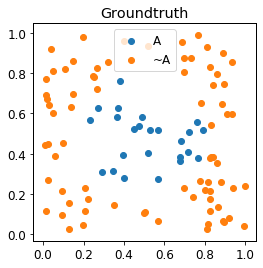

In [2]:
batch_size=64
nr_samples = 100
nr_samples_train = 50
data = np.random.uniform([0,0],[1,1],(nr_samples,2))
labels = np.sum(np.square(data-[.5,.5]),axis=1)<.09

from torch.utils.data import Dataset

class PointsDataset(Dataset):
    def __init__(self, data,labels):
        self.data = data
        self.labels=labels

    def __getitem__(self, item):
        return {'x': self.data[item], 'label': self.labels[item]}

    def __len__(self):
        return len(self.items)

# 400 examples for training; 100 examples for training
# ds_train = tf.data.Dataset\
#         .from_tensor_slices((data[:nr_samples_train],labels[:nr_samples_train]))\
#         .batch(batch_size)
# ds_test = tf.data.Dataset\
#         .from_tensor_slices((data[nr_samples_train:],labels[nr_samples_train:]))\
#         .batch(batch_size)
ds_train = PointsDataset(data[:nr_samples_train],labels[:nr_samples_train])
ds_test = PointsDataset(data[nr_samples_train:],labels[nr_samples_train:])

plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')
plt.title("Groundtruth")
plt.legend()
plt.show()


Define the predicate $A$. $A$ has arity 1 (single argument). The dimension of the argument is 2 (since the domain is $[0,1]^2$).

In [3]:
class A_gr(torch.nn.Module):
    def __init__(self):
        super(A_gr, self).__init__()
        self.l1 = torch.nn.Linear(2, 16, True)
        self.a1 = torch.relu
        self.l2 = torch.nn.Linear(16, 16, True)
        self.a2 = torch.relu
        self.l3 = torch.nn.Linear(16, 1, False)
        self.a3 = torch.sigmoid

    def forward(self, x):
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x

A = ltn.Predicate('A',A_gr())

Import some operators to write the axioms.

In [4]:
Not = ltn.NOT
And = ltn.AND
Or = ltn.OR
Implies = ltn.IMPLY
Forall = ltn.ALL
Exists = ltn.ANY

Now we add some facts to the knowledgebase. We express that for all points in $\mathrm{data\_A}$, $A$ should be true. For all points in $\mathrm{data\_not\_A}$, $A$ is not true. 

In [5]:
theory=ltn.Theory()

x_pos=ltn.Variable('x_pos')
x_neg=ltn.Variable('x_neg')

theory.add_axiom(Forall(x_pos,A(x_pos)))
theory.add_axiom(Forall(x_neg,A(x_neg)))

def axioms(data, labels,theory):
    sat_level=theory.satisfies(x_pos=labels,x_neg=np.logical_not(labels))
    return sat_level

In [6]:
raise NotImplementedException()

NameError: name 'NotImplementedException' is not defined

Initialize all layers and the static graph.

In [ ]:
for _data, _labels in ds_test:
    print("Initial sat level %.5f"%axioms(_data, _labels))
    break


Train on the knowledgebase.

In [ ]:
mean_metrics = tf.keras.metrics.Mean()

trainable_variables = A.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for epoch in range(2000):
    for _data, _labels in ds_train:
        with tf.GradientTape() as tape:
            loss = 1. - axioms(_data, _labels)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%100 == 0:
        mean_metrics.reset_states()
        for _data, _labels in ds_test:
            mean_metrics(axioms(_data, _labels))
        print("Epoch %d: Sat Level %.3f"%(epoch, mean_metrics.result() ))
mean_metrics.reset_states()
for _data, _labels in ds_test:
    mean_metrics(axioms(_data, _labels))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, mean_metrics.result() ))

The following queries the database on training data and test data. Vizualisation show the extent of generalization.

In [ ]:
fig = plt.figure(figsize=(9, 11))

plt.subplots_adjust(wspace=0.2,hspace=0.3)
ax = plt.subplot2grid((3,8),(0,2),colspan=4)
ax.set_title("groundtruth")
ax.scatter(data[labels][:,0],data[labels][:,1],label='A')
ax.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')
ax.legend()

# Training data
x = ltn.Variable("x",data[:nr_samples_train])
fig.add_subplot(3, 2, 3)
result=A(x)
plt.title("A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 4)
result=Not(A(x))
plt.title("~A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

# Test data
x = ltn.Variable("x",data[nr_samples_train:])
fig.add_subplot(3, 2, 5)

result=A(x)
plt.title("A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.tensor.numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 6)
result=Not(A(x))
plt.title("~A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.tensor.numpy().squeeze())
plt.colorbar()
plt.savefig("ex_binary_testing.pdf")
plt.show()